---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

## Data Cleaning for assets

In [318]:
# File paths for all datasets
file_paths = {
    "sp500": "../../data/processed-data/S&P_500_cleaned.csv",
    "oil": "../../data/processed-data/Crude_Oil_cleaned.csv",
    "gold": "../../data/processed-data/Gold_cleaned.csv",
    "nasdaq": "../../data/processed-data/Nasdaq_cleaned.csv",
    "dow_jones": "../../data/processed-data/Dow_Jones_cleaned.csv"
}

# Load all datasets into a dictionary
datasets = {name: pd.read_csv(path, parse_dates=["index"]) for name, path in file_paths.items()}

# Initialize merged_data with S&P 500 dataset
asset_data = datasets["sp500"]

# Merge datasets iteratively with others
for name, df in datasets.items():
    if name != "sp500":  # Skip the first dataset (already initialized)
        asset_data = pd.merge(asset_data, df, on="index", suffixes=(None, f"_{name}"))

# Handle missing data by forward-filling and dropping any remaining NaNs
asset_data = asset_data.fillna(method='ffill').dropna()

sp500_columns = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'MA_50', 'MA_200', 
    'Daily_Return', 'Volatility', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 
    'Signal_Line', 'High_Low', 'High_Close', 'Low_Close', 'True_Range', 
    'ATR', 'OBV', 'RSI_Lag1', 'MACD_Lag1', 'Close_Lag1', 'Volume_Lag1', 
    'RSI_Lag2', 'MACD_Lag2', 'Close_Lag2', 'Volume_Lag2', 'RSI_Lag3', 
    'MACD_Lag3', 'Close_Lag3', 'Volume_Lag3', 'Target', 'Future_Return_5D'
]

# Add the prefix "_sp500" only to the SP500 columns
asset_data.rename(columns={col: f"{col}_sp500" for col in sp500_columns}, inplace=True)

# Output the first few rows to check the new column names
asset_data.head()
# Save the merged dataset
asset_data.to_csv("../../data/processed-data/merged_assets.csv", index=False)


/var/folders/1z/n1k_hhl168s2rqld4kqxxr880000gn/T/ipykernel_78437/2584913618.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  asset_data = asset_data.fillna(method='ffill').dropna()


## Merge macro data and asset data

In [319]:
# Load macroeconomic data (monthly data)
macro_data = pd.read_csv("../../data/processed-data/macro_series_cleaned.csv")
macro_data.head()

# 1. Ensure the `date` column is in datetime format
macro_data['date'] = pd.to_datetime(macro_data['date'])

# Extract year and month from the `date` column
macro_data['year_month'] = macro_data['date'].dt.to_period('M').astype(str)  # Format: YYYY-MM

# Check for missing values and fill them
macro_data.fillna(method='ffill', inplace=True)  # Forward fill any missing values

# 2. Generate derived features
# Calculate year-over-year (YoY) and month-over-month (MoM) growth rates
macro_data['GDP_YoY'] = macro_data['GDP'].pct_change(12) * 100  # YoY growth rate for GDP (%)
macro_data['GDP_MoM'] = macro_data['GDP'].pct_change(1) * 100   # MoM growth rate for GDP (%)
macro_data['CPI_YoY'] = macro_data['CPI'].pct_change(12) * 100  # YoY growth rate for CPI (%)

# Create lagged features
macro_data['GDP_Lag1'] = macro_data['GDP'].shift(1)  # GDP lagged by one month
macro_data['CPI_Lag1'] = macro_data['CPI'].shift(1)  # CPI lagged by one month

# Load asset data (daily data)
asset_data['date'] = pd.to_datetime(asset_data['index'])  # Convert `index` to datetime

# Extract year and month from the asset data
asset_data['year_month'] = asset_data['date'].dt.to_period('M').astype(str)  # Format: YYYY-MM

# Downsample asset data (daily frequency -> monthly frequency)
# Group by `year_month` and take the last available data for each month
asset_data_monthly = asset_data.groupby('year_month').last().reset_index()

# 3. Merge macroeconomic data with asset data
# Merge both datasets based on the `year_month` column
macro_data = pd.merge(macro_data, asset_data_monthly, on='year_month', how='left')

# Handle missing values in the merged dataset
macro_data.fillna(method='ffill', inplace=True)  # Forward fill missing values
macro_data.fillna(method='bfill', inplace=True)  # Backward fill missing values (if needed)

# 4. Standardize the data
# Select the columns to be standardized
columns_to_scale = ['GDP', 'CPI', 'Unemployment', 'FedFundsRate', 'M2',
                    'Umscent', 'real_estate', 'Exports', 'Imports',
                    'GDP_YoY', 'GDP_MoM', 'CPI_YoY', 'GDP_Lag1', 'CPI_Lag1']

scaler = StandardScaler()
# Apply standard scaling (mean = 0, std dev = 1) to the selected columns
macro_data[columns_to_scale] = scaler.fit_transform(macro_data[columns_to_scale])

# 5. Inspect the processed data
print(macro_data.head())

# Save the processed dataset to a CSV file
macro_data.to_csv("../../data/processed-data/macro_data.csv", index=False)

/var/folders/1z/n1k_hhl168s2rqld4kqxxr880000gn/T/ipykernel_78437/4291704790.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='ffill', inplace=True)  # Forward fill any missing values
/var/folders/1z/n1k_hhl168s2rqld4kqxxr880000gn/T/ipykernel_78437/4291704790.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='ffill', inplace=True)  # Forward fill missing values
/var/folders/1z/n1k_hhl168s2rqld4kqxxr880000gn/T/ipykernel_78437/4291704790.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='bfill', inplace=True)  # Backward fill missing values (if needed)


      date_x       GDP       CPI  Unemployment  FedFundsRate        M2  \
0 2000-01-01 -1.419333 -1.594756     -0.867414      1.754717 -1.259868   
1 2000-02-01 -1.371109 -1.576251     -0.816379      1.893549 -1.257353   
2 2000-03-01 -1.371109 -1.549815     -0.867414      1.953048 -1.251527   
3 2000-04-01 -1.371735 -1.552459     -0.969482      2.037339 -1.240917   
4 2000-05-01 -1.371109 -1.544528     -0.867414      2.161296 -1.243205   

    Umscent  real_estate   Exports   Imports  ...  MACD_Lag2_dow_jones  \
0  2.199732    -1.446673 -1.458048 -1.614811  ...           -65.554617   
1  2.146820    -1.436692 -1.391110 -1.523412  ...           -65.554617   
2  1.829348    -1.421047 -1.391110 -1.523412  ...           -65.554617   
3  1.988084    -1.402256 -1.395372 -1.552202  ...           -65.554617   
4  2.101467    -1.381961 -1.391110 -1.523412  ...           -65.554617   

   Close_Lag2_dow_jones  Volume_Lag2_dow_jones  RSI_Lag3_dow_jones  \
0          10090.900391            16098

## Select key features

In [320]:

# Select key features for analysis
selected_features = [
    'GDP', 'CPI', 'Unemployment', 'FedFundsRate', 'M2', 'Umscent',  # Macroeconomic data
    'MA_50_oil', 'MA_50_gold', 'MA_50_nasdaq', 'MA_50_dow_jones',   # Technical indicators
    'RSI_oil', 'RSI_gold', 'RSI_nasdaq', 'RSI_dow_jones',           # RSI indicators
    'MACD_oil', 'MACD_gold', 'MACD_nasdaq', 'MACD_dow_jones',       # MACD indicators
    'Future_Return_5D_oil', 'Future_Return_5D_gold',                # Target variables
    'Future_Return_5D_nasdaq', 'Future_Return_5D_dow_jones',
    'MA_50_sp500', 'RSI_sp500', 'MACD_sp500', 'Future_Return_5D_sp500',
    'Close_oil', 'Close_gold', 'Close_nasdaq', 'Close_dow_jones', 'Close_sp500'
]

selected_features_2 = [
    'Close_oil', 'Close_gold', 'Close_nasdaq', 'Close_dow_jones', 'Close_sp500',
    'MA_50_oil', 'MA_50_gold', 'MA_50_nasdaq', 'MA_50_dow_jones',   # Technical indicators
    'RSI_oil', 'RSI_gold', 'RSI_nasdaq', 'RSI_dow_jones',           # RSI indicators
    'MACD_oil', 'MACD_gold', 'MACD_nasdaq', 'MACD_dow_jones',       # MACD indicators
    'Future_Return_5D_oil', 'Future_Return_5D_gold',                # Target variables
    'Future_Return_5D_nasdaq', 'Future_Return_5D_dow_jones',
    'MA_50_sp500', 'RSI_sp500', 'MACD_sp500', 'Future_Return_5D_sp500'
]

# Filter the dataset to include only the selected features
macro_data = macro_data[selected_features]

# Drop rows with missing values (if any remain after filling)
macro_data.dropna(inplace=True)


# Filter the dataset to include only the selected features
asset_data = asset_data[selected_features_2]

# Drop rows with missing values (if any remain after filling)
asset_data.dropna(inplace=True)

## Multi-market linkage analysis (correlation and PCA)


Index(['Close_oil', 'Close_gold', 'Close_nasdaq', 'Close_dow_jones',
       'Close_sp500', 'MA_50_oil', 'MA_50_gold', 'MA_50_nasdaq',
       'MA_50_dow_jones', 'RSI_oil', 'RSI_gold', 'RSI_nasdaq', 'RSI_dow_jones',
       'MACD_oil', 'MACD_gold', 'MACD_nasdaq', 'MACD_dow_jones',
       'Future_Return_5D_oil', 'Future_Return_5D_gold',
       'Future_Return_5D_nasdaq', 'Future_Return_5D_dow_jones', 'MA_50_sp500',
       'RSI_sp500', 'MACD_sp500', 'Future_Return_5D_sp500'],
      dtype='object')


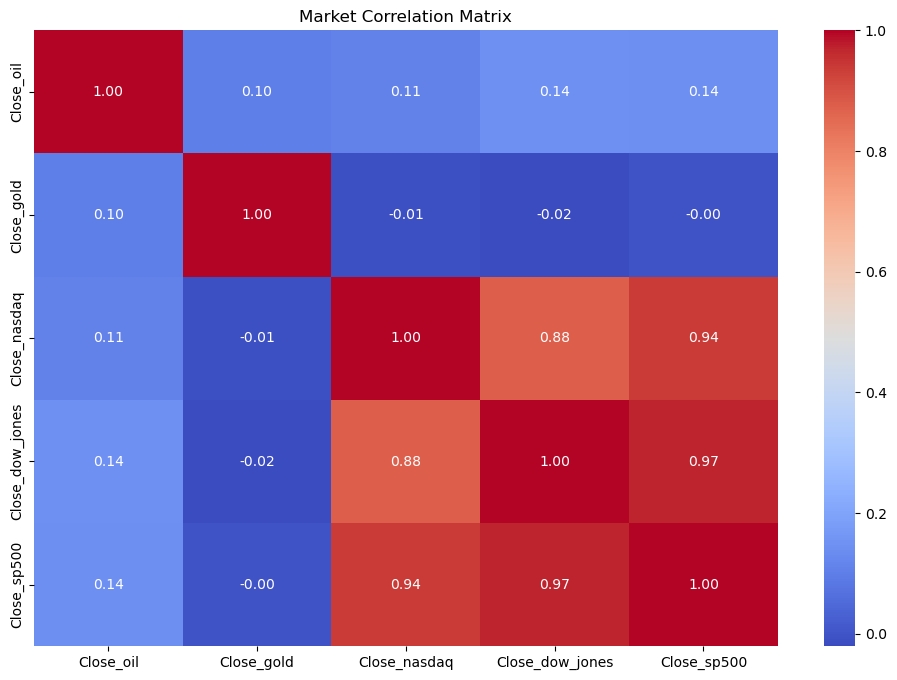

Explained variance ratio: [0.56997664 0.2343595 ]


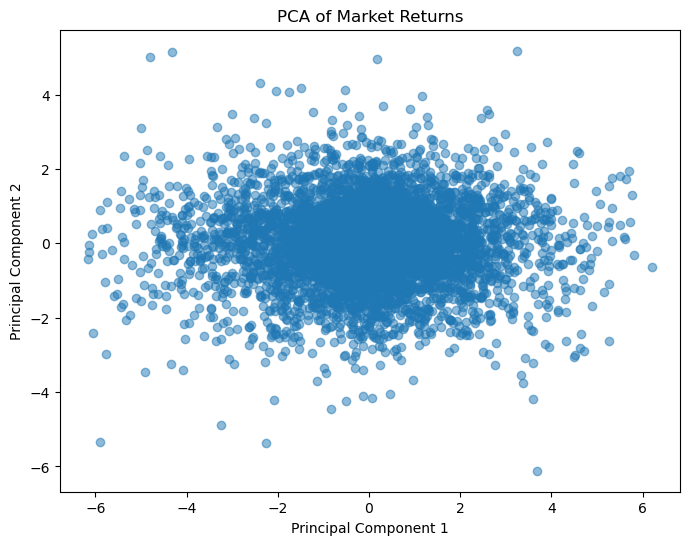

In [321]:
# Questions
# Are there any connections between the behavioral patterns of various markets (such as S&P 500, gold, crude oil, Nasdaq, etc.)?
# Is it possible to divide the market into different categories (such as high-risk vs. safe-haven assets) based on market characteristics (such as RSI, MACD, rainbows, etc.)?

save_path = "../../data/visualized-data"
import os
os.makedirs(save_path, exist_ok=True)

# -------------------------------
# Step 1: Calculate Daily Returns
# -------------------------------

# Calculate daily returns from closing prices
returns = asset_data.filter(like='Close').pct_change().dropna()

# Compute the correlation matrix
correlation_matrix = returns.corr()
print(asset_data.columns)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Market Correlation Matrix")
plt.savefig(os.path.join(save_path, 'market_correlation_matrix.png'))
plt.show()
plt.close()

# -------------------------------
# Step 2: Remove Outliers
# -------------------------------

# Calculate upper and lower limits (3 standard deviations from the mean)
upper_limit = returns.mean() + 3 * returns.std()
lower_limit = returns.mean() - 3 * returns.std()

# Remove outliers based on the calculated limits
filtered_returns = returns[(returns < upper_limit) & (returns > lower_limit)].dropna()

# -------------------------------
# Step 3: Standardize the Data
# -------------------------------

# Standardize the filtered returns
scaler = StandardScaler()
filtered_returns_scaled = scaler.fit_transform(filtered_returns)

# -------------------------------
# Step 4: PCA for Dimensionality Reduction
# -------------------------------

# Perform PCA and reduce to 2 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_returns_scaled)

# Print the explained variance ratio of the first two principal components
print("Explained variance ratio:", pca.explained_variance_ratio_)

# -------------------------------
# Step 5: Visualize PCA Results
# -------------------------------

# Scatter plot of the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.5)
plt.title("PCA of Market Returns")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig(os.path.join(save_path, 'market_pca_results.png'))
plt.show()
plt.close()

## Multi-market linkage analysis (kmeans)

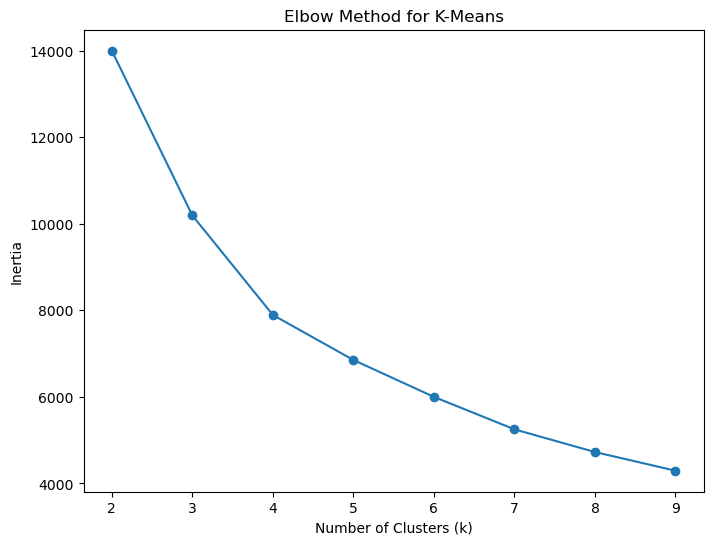

Silhouette Score: 0.3465435410464012


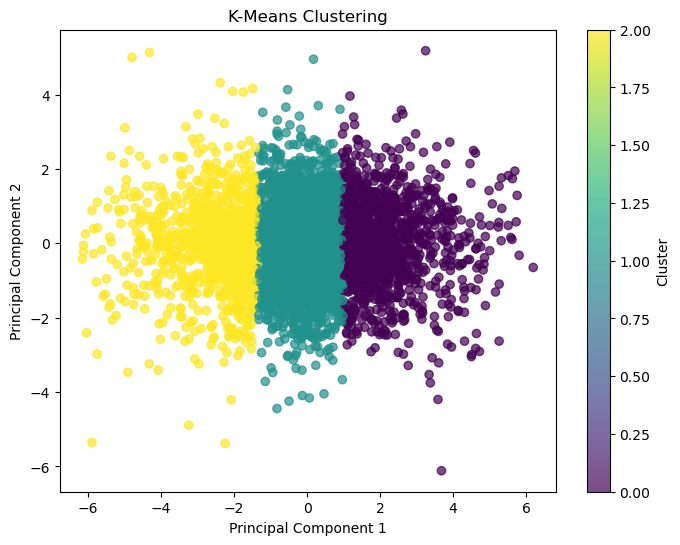

In [322]:
# -------------------------------
# Step 6: Kmeans
# -------------------------------

# -------------------------------
#   Step 1: Elbow Method to Determine Optimal k
# -------------------------------
inertia = []
range_k = range(2, 10)
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range_k, inertia, marker='o')
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.savefig(os.path.join(save_path, 'kmeans_elbow_curve.png'))
plt.show()
plt.close()

# -------------------------------
#   Step 2: Fit K-Means with Optimal k
# -------------------------------
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_data)

# Evaluate clustering with Silhouette Score
silhouette_avg = silhouette_score(pca_data, kmeans_labels)
print("Silhouette Score:", silhouette_avg)

# -------------------------------
#   Step 3: Visualize K-Means Clustering Results
# -------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.savefig(os.path.join(save_path, 'kmeans_clustering_results.png'))
plt.show()
plt.close()

## PCA Clustered Feature Distributions

Cluster Means:
               PC1       PC2
Cluster                    
0        2.061786  0.017502
1       -0.091093 -0.008499
2       -2.607793  0.003936


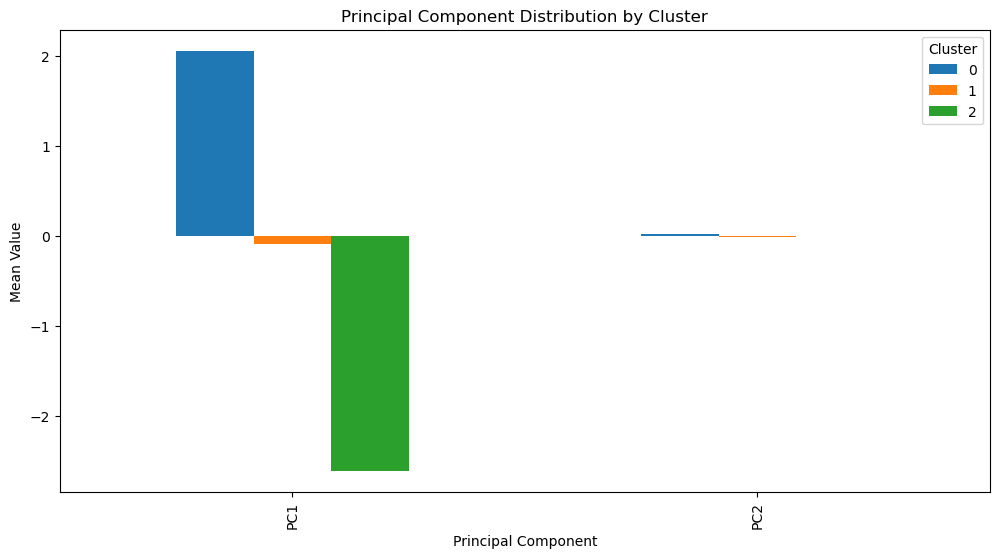

PCA Components:
 [[ 1.40296075e-01 -4.31707754e-05  5.59111904e-01  5.68705657e-01
   5.86757841e-01]
 [ 6.65914113e-01  7.39689815e-01 -7.00063894e-02 -5.36870662e-02
  -4.04249546e-02]]
Length of asset_data after alignment: 5650
Length of kmeans_labels: 5650


<Figure size 1400x800 with 0 Axes>

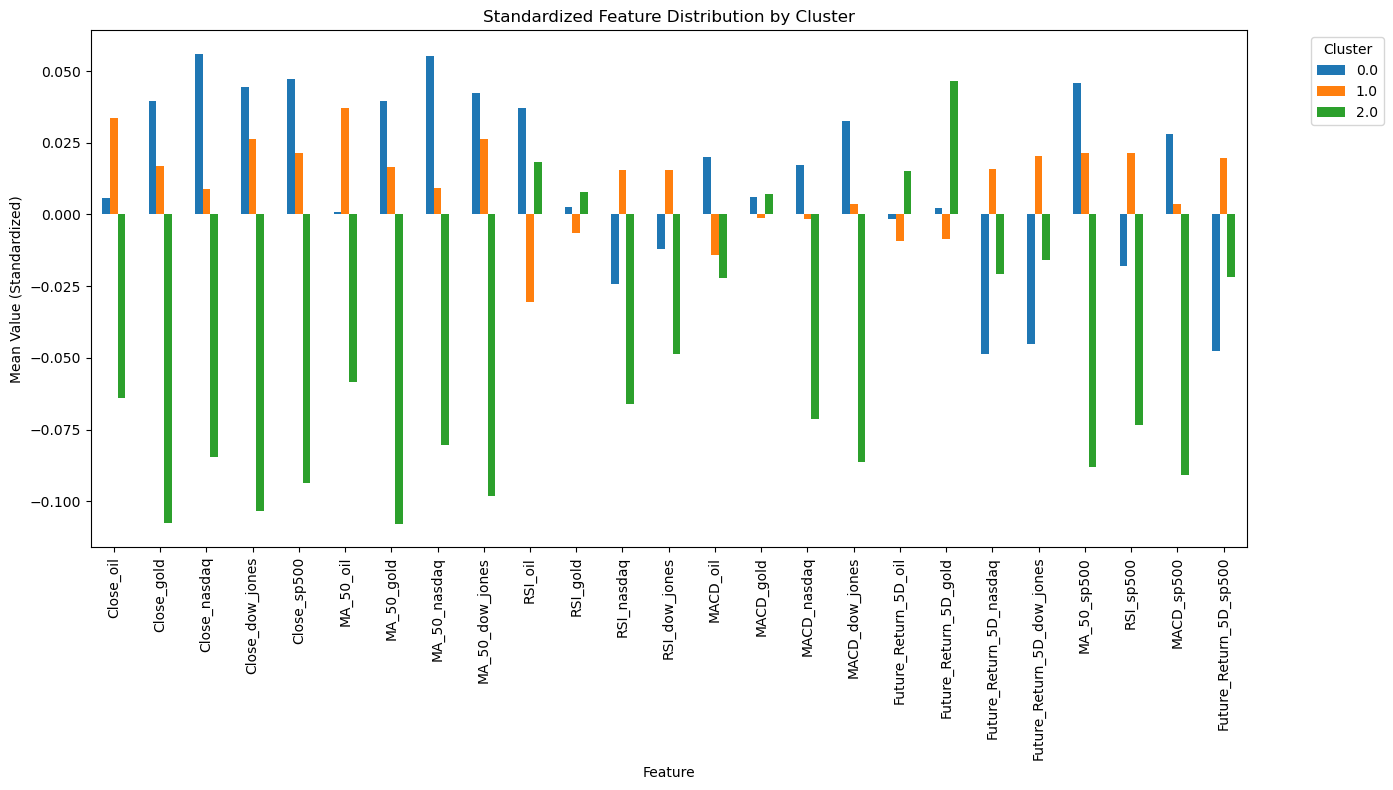

<Figure size 1400x800 with 0 Axes>

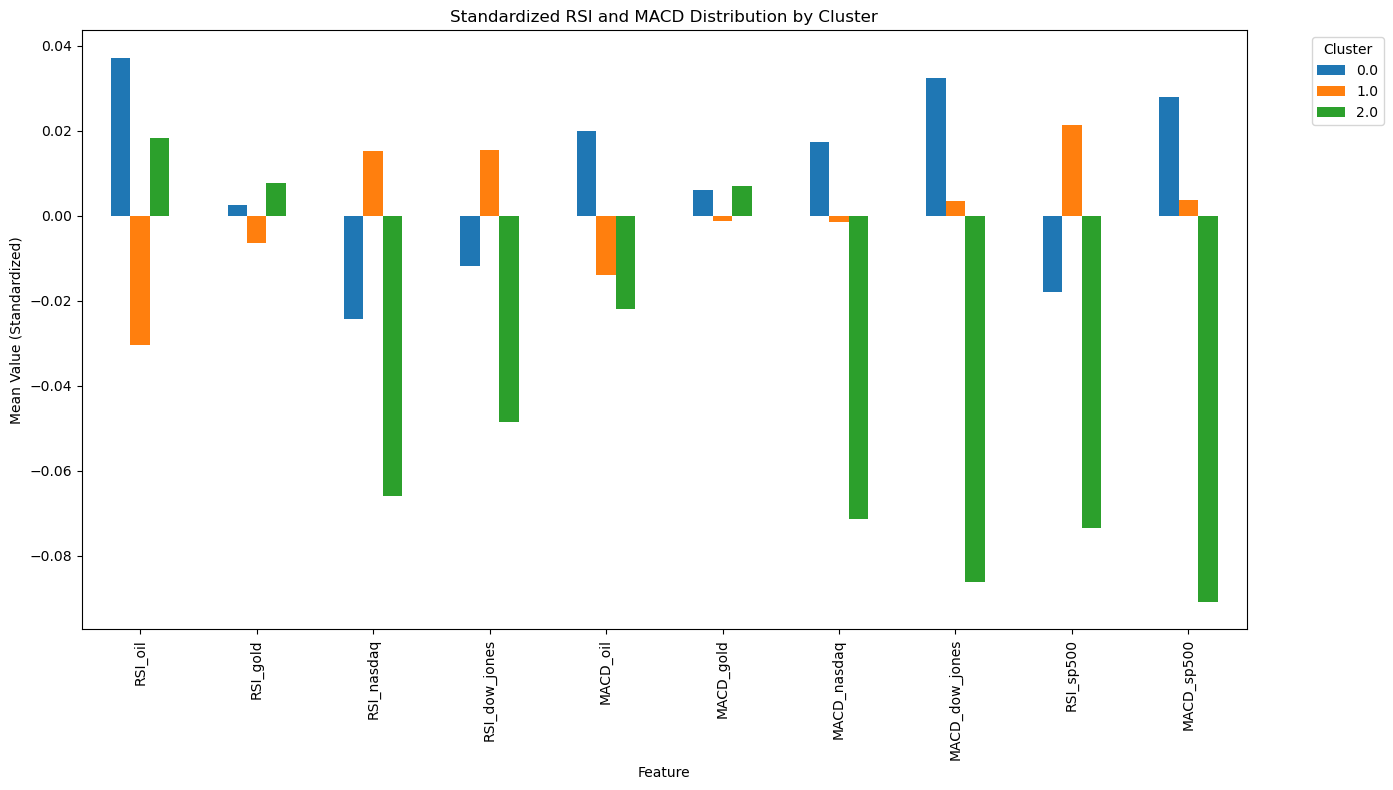

In [323]:
# -------------------------------
#   Step 7: PCA Dimensionality Reduction and Clustering
# -------------------------------

# Create a DataFrame for PCA-transformed data
clustered_data = pd.DataFrame(pca_data, columns=["PC1", "PC2"])  # Principal Component Data
clustered_data["Cluster"] = kmeans_labels  # Add cluster labels

# Calculate the mean value of each principal component for each cluster
cluster_means = clustered_data.groupby("Cluster").mean()
print("Cluster Means:\n", cluster_means)

# Visualize the distribution of principal components by cluster
cluster_means.T.plot(kind='bar', figsize=(12, 6))
plt.title("Principal Component Distribution by Cluster")
plt.ylabel("Mean Value")
plt.xlabel("Principal Component")
plt.legend(title="Cluster")
plt.savefig(os.path.join(save_path, 'pc_distribution_by_cluster.png'))
plt.show()
plt.close()

# Display the PCA loading matrix (components)
print("PCA Components:\n", pca.components_)

# -------------------------------
#   Step 8: Combine Cluster Labels with Original Feature Data
# -------------------------------
asset_data = asset_data.loc[filtered_returns.index] 
print("Length of asset_data after alignment:", len(asset_data))
print("Length of kmeans_labels:", len(kmeans_labels))

if len(asset_data) != len(kmeans_labels):
    asset_data = asset_data.iloc[:len(kmeans_labels)]

original_clustered_data = asset_data.copy()
original_clustered_data["Cluster"] = kmeans_labels

# -------------------------------
#   Step 9: Standardize the Feature Data
# -------------------------------

# Extract features (excluding the cluster labels)
features = original_clustered_data.drop(columns=["Cluster"])

# Use StandardScaler to standardize the feature data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert standardized data back to a DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
features_scaled_df["Cluster"] = original_clustered_data["Cluster"]  # Add cluster labels

# -------------------------------
#   Step 10: Calculate Mean of Standardized Features by Cluster
# -------------------------------

# Group by cluster and calculate the mean of each feature
scaled_cluster_means = features_scaled_df.groupby("Cluster").mean()

# -------------------------------
#   Step 11: Visualize Clustered Feature Distributions
# -------------------------------

# Plot the mean values of standardized features for each cluster
plt.figure(figsize=(14, 8))
scaled_cluster_means.T.plot(kind="bar", figsize=(14, 8))
plt.title("Standardized Feature Distribution by Cluster")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Feature")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'feature_distribution_by_cluster.png'))
plt.show()
plt.close()

# -------------------------------
#   Step 12: Filter Features for Specific Analysis (e.g., RSI and MACD)
# -------------------------------

# Select only RSI and MACD-related features for focused analysis
selected_features = [col for col in features.columns if "RSI" in col or "MACD" in col]

# Calculate the mean values of the selected features by cluster
filtered_cluster_means = scaled_cluster_means[selected_features]

# Plot the distribution of the selected features by cluster
plt.figure(figsize=(14, 8))
filtered_cluster_means.T.plot(kind="bar", figsize=(14, 8))
plt.title("Standardized RSI and MACD Distribution by Cluster")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Feature")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'rsi_macd_distribution_by_cluster.png'))
plt.show()
plt.close()

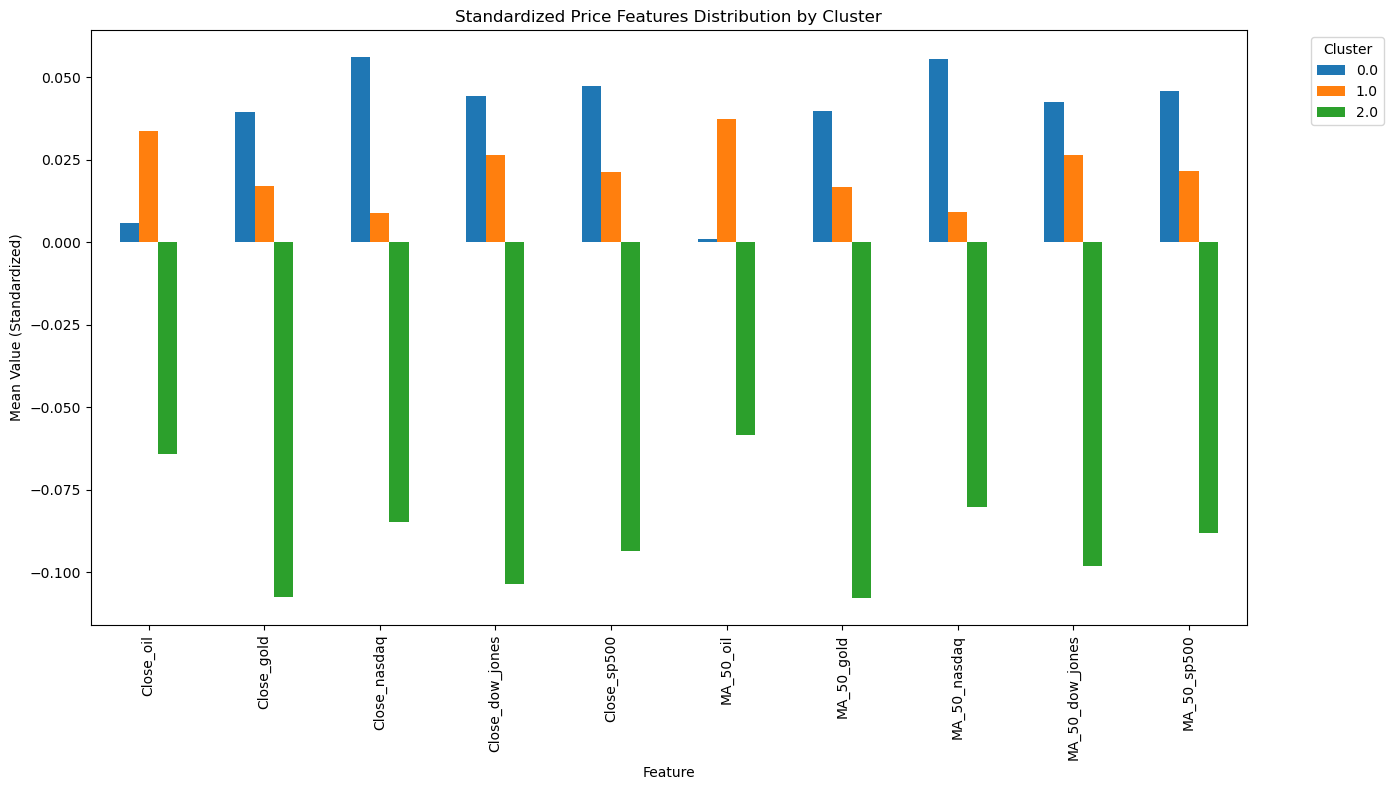

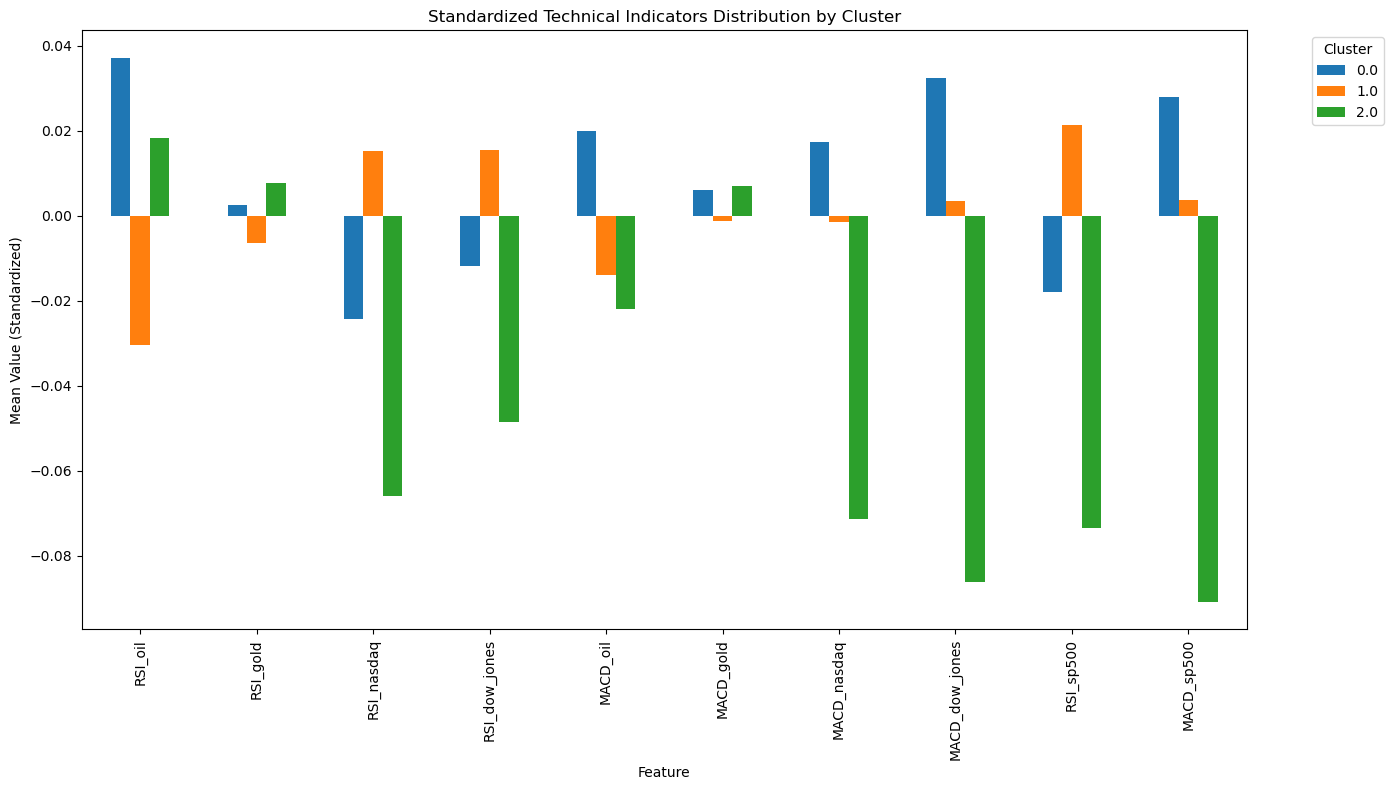

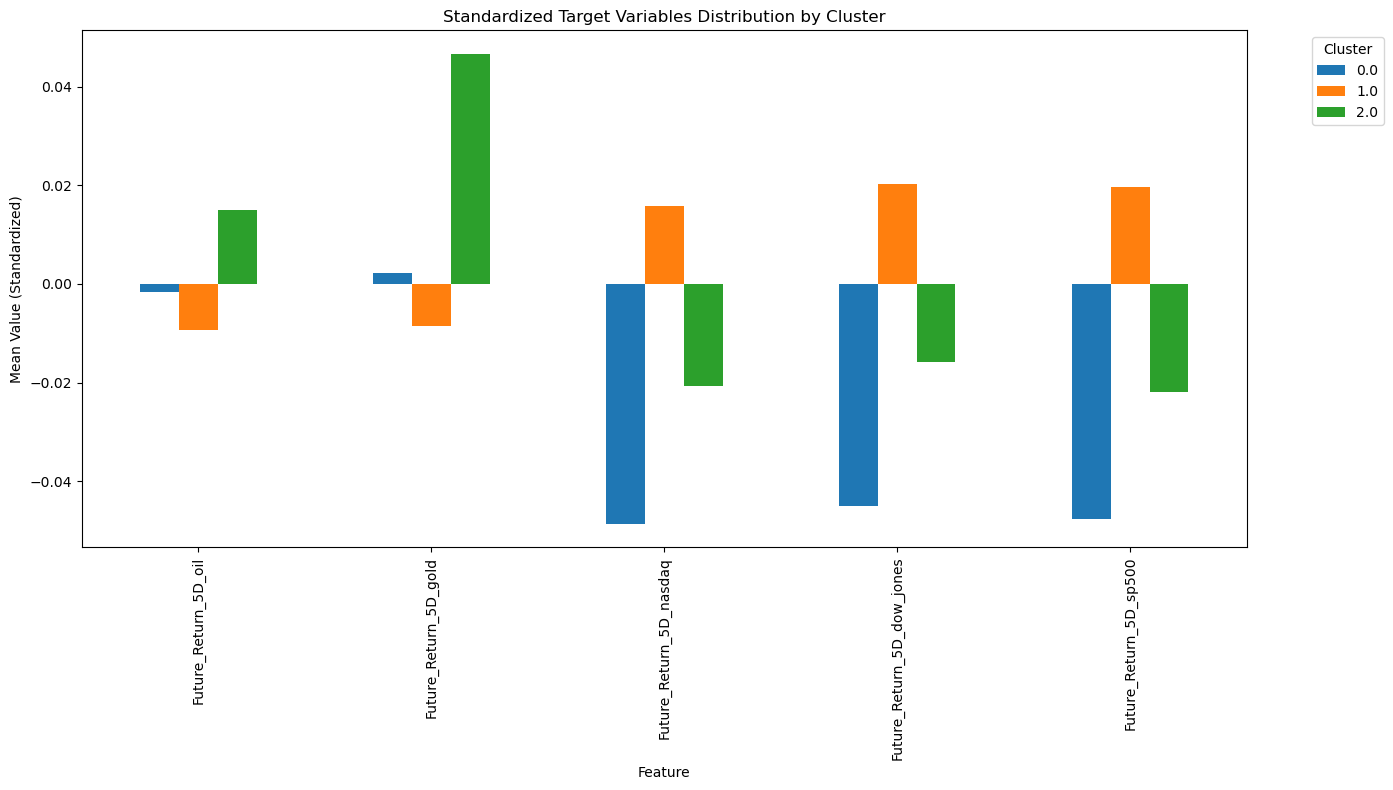

In [324]:
# -------------------------------
#   Step 13: Group and Filter Features by Categories
# -------------------------------

# Group features based on their categories
# Price-related features: Columns containing "Close" or "MA_50"
price_features = [col for col in features.columns if "Close" in col or "MA_50" in col]

# Technical indicators: Columns containing "RSI" or "MACD"
indicator_features = [col for col in features.columns if "RSI" in col or "MACD" in col]

# Target variables: Columns containing "Future_Return"
target_features = [col for col in features.columns if "Future_Return" in col]

# -------------------------------
#   Step 14: Visualize Price Features by Cluster
# -------------------------------

# Plot the standardized mean distribution of price-related features by cluster
scaled_cluster_means[price_features].T.plot(kind="bar", figsize=(14, 8))
plt.title("Standardized Price Features Distribution by Cluster")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Feature")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'price_features_by_cluster.png'))
plt.show()
plt.close()

# -------------------------------
#   Step 15: Visualize Technical Indicators by Cluster
# -------------------------------

# Plot the standardized mean distribution of technical indicators (RSI and MACD) by cluster
scaled_cluster_means[indicator_features].T.plot(kind="bar", figsize=(14, 8))
plt.title("Standardized Technical Indicators Distribution by Cluster")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Feature")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_variables_by_cluster.png'))
plt.show()
plt.close()

# -------------------------------
#   Step 16: Visualize Target Variables by Cluster
# -------------------------------

# Plot the standardized mean distribution of target variables (Future_Return features) by cluster
scaled_cluster_means[target_features].T.plot(kind="bar", figsize=(14, 8))
plt.title("Standardized Target Variables Distribution by Cluster")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Feature")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'technical_indicators_by_cluster.png'))
plt.show()
plt.close()

## The relationship between macroeconomics and market performance

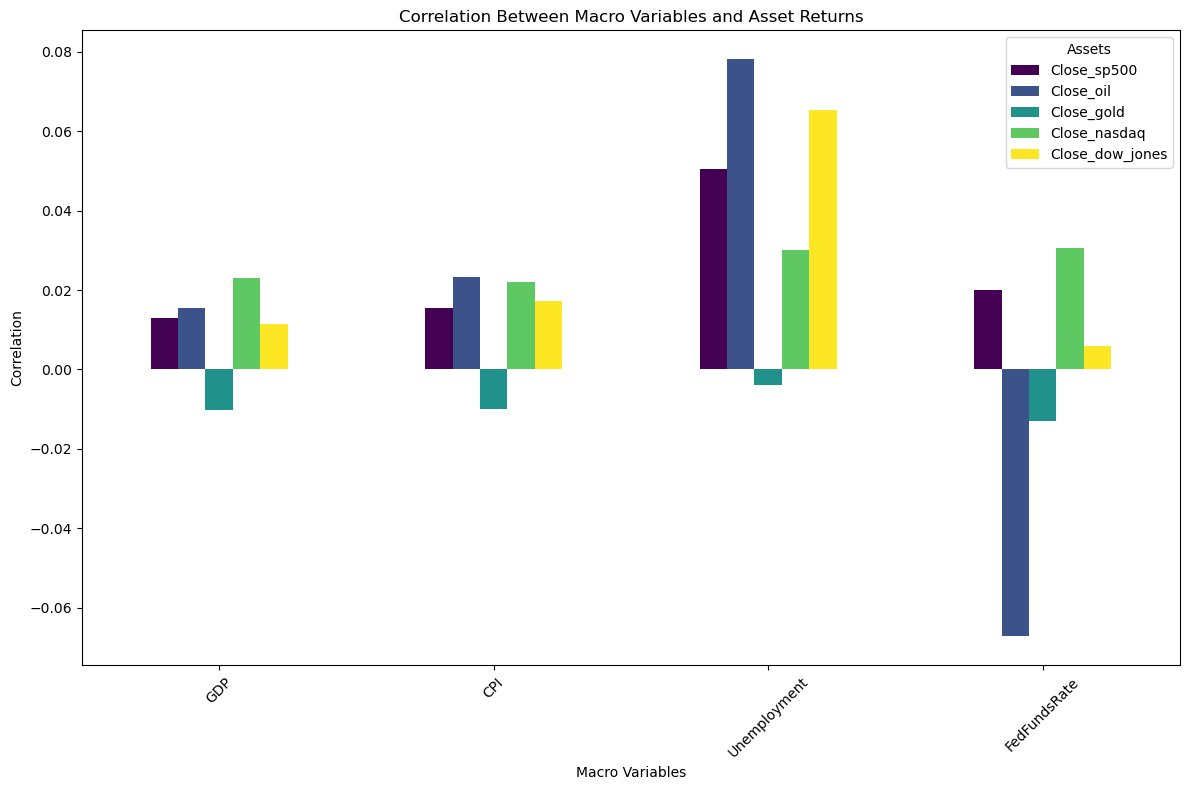

Granger Causality Test: GDP -> Close_sp500
Lag 1: p-value = 0.0137
Lag 2: p-value = 0.0206
Lag 3: p-value = 0.0013
Lag 4: p-value = 0.0000
--------------------------------------------------
Granger Causality Test: CPI -> Close_sp500


/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1: p-value = 0.0000
Lag 2: p-value = 0.0001
Lag 3: p-value = 0.0001
Lag 4: p-value = 0.0001
--------------------------------------------------
Granger Causality Test: Unemployment -> Close_sp500
Lag 1: p-value = 0.0229
Lag 2: p-value = 0.0000
Lag 3: p-value = 0.0000
Lag 4: p-value = 0.0000
--------------------------------------------------
Granger Causality Test: FedFundsRate -> Close_sp500
Lag 1: p-value = 0.0014
Lag 2: p-value = 0.0780
Lag 3: p-value = 0.0050
Lag 4: p-value = 0.0812
--------------------------------------------------
Granger Causality Test: GDP -> Close_oil
Lag 1: p-value = 0.6948
Lag 2: p-value = 0.0066
Lag 3: p-value = 0.0030
Lag 4: p-value = 0.0012
--------------------------------------------------
Granger Causality Test: CPI -> Close_oil
Lag 1: p-value = 0.1169
Lag 2: p-value = 0.0000
Lag 3: p-value = 0.0000
Lag 4: p-value = 0.0000
--------------------------------------------------
Granger Causality Test: Unemployment -> Close_oil
Lag 1: p-value = 0.5079
Lag 2

/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.w

Lag 1: p-value = 0.0587
Lag 2: p-value = 0.1552
Lag 3: p-value = 0.0478
Lag 4: p-value = 0.0884
--------------------------------------------------
Granger Causality Test: GDP -> Close_gold


/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1: p-value = 0.5160
Lag 2: p-value = 0.5347
Lag 3: p-value = 0.1150
Lag 4: p-value = 0.2512
--------------------------------------------------
Granger Causality Test: CPI -> Close_gold
Lag 1: p-value = 0.9421
Lag 2: p-value = 0.0844
Lag 3: p-value = 0.2157
Lag 4: p-value = 0.2093
--------------------------------------------------
Granger Causality Test: Unemployment -> Close_gold
Lag 1: p-value = 0.5553
Lag 2: p-value = 0.8625
Lag 3: p-value = 0.8373
Lag 4: p-value = 0.8699
--------------------------------------------------
Granger Causality Test: FedFundsRate -> Close_gold
Lag 1: p-value = 0.0388
Lag 2: p-value = 0.8806
Lag 3: p-value = 0.6924
Lag 4: p-value = 0.9076
--------------------------------------------------
Granger Causality Test: GDP -> Close_nasdaq
Lag 1: p-value = 0.0118
Lag 2: p-value = 0.0069
Lag 3: p-value = 0.0009
Lag 4: p-value = 0.0006
--------------------------------------------------
Granger Causality Test: CPI -> Close_nasdaq
Lag 1: p-value = 0.0000
Lag 2: p-

/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.w

Lag 1: p-value = 0.0375
Lag 2: p-value = 0.0008
Lag 3: p-value = 0.0001
Lag 4: p-value = 0.0004
--------------------------------------------------
Granger Causality Test: FedFundsRate -> Close_nasdaq
Lag 1: p-value = 0.0034
Lag 2: p-value = 0.2720
Lag 3: p-value = 0.0258
Lag 4: p-value = 0.2066
--------------------------------------------------
Granger Causality Test: GDP -> Close_dow_jones
Lag 1: p-value = 0.0044
Lag 2: p-value = 0.0135
Lag 3: p-value = 0.0008
Lag 4: p-value = 0.0000
--------------------------------------------------
Granger Causality Test: CPI -> Close_dow_jones
Lag 1: p-value = 0.0000
Lag 2: p-value = 0.0000
Lag 3: p-value = 0.0001
Lag 4: p-value = 0.0000
--------------------------------------------------
Granger Causality Test: Unemployment -> Close_dow_jones
Lag 1: p-value = 0.0211
Lag 2: p-value = 0.0000
Lag 3: p-value = 0.0000
Lag 4: p-value = 0.0000
--------------------------------------------------
Granger Causality Test: FedFundsRate -> Close_dow_jones
Lag 1:

/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/qqmian/opt/anaconda3/envs/dsan5400/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.w

In [325]:

# question:
# How do macroeconomic data (such as GDP growth, CPI, unemployment rate, federal funds rate, etc.) affect the performance of different markets?
# Is the behavior of different markets driven by the same macroeconomic indicators?

from statsmodels.tsa.stattools import grangercausalitytests

# -------------------------------
#   Step 1: Define Macro Features and Asset Returns
# -------------------------------
# Define macroeconomic features
macro_features = ['GDP', 'CPI', 'Unemployment', 'FedFundsRate']

# Define asset return columns (e.g., S&P 500, oil, gold, etc.)
asset_features = ['Close_sp500', 'Close_oil', 'Close_gold', 'Close_nasdaq', 'Close_dow_jones']

# -------------------------------
#   Step 2: Calculate Correlations Between Macro Variables and Asset Returns
# -------------------------------
# Create an empty DataFrame to store correlations
correlations = pd.DataFrame(index=macro_features, columns=asset_features)

# Loop through each asset and calculate correlations with macro features
for asset in asset_features:
    correlations[asset] = macro_data[macro_features].corrwith(returns[asset])

# Visualize the correlations
correlations.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title("Correlation Between Macro Variables and Asset Returns")
plt.ylabel("Correlation")
plt.xlabel("Macro Variables")
plt.xticks(rotation=45)
plt.legend(title="Assets")
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'macro_asset_correlations.png'))
plt.show()
plt.close()

# -------------------------------
#   Step 3: Perform Granger Causality Tests for Each Asset
# -------------------------------
# Define max lag for Granger causality tests
max_lag = 4

# Loop through each asset and test causality with macro variables
granger_results = {}
for asset in asset_features:
    for macro in macro_features:
        # Align data and drop missing values
        data = macro_data[[macro, asset]].dropna()
        # Perform Granger causality test
        print(f"Granger Causality Test: {macro} -> {asset}")
        result = grangercausalitytests(data, maxlag=max_lag, verbose=False)
        granger_results[(macro, asset)] = result
        # Display p-values for each lag
        for lag, test_result in result.items():
            p_value = test_result[0]['ssr_chi2test'][1]
            print(f"Lag {lag}: p-value = {p_value:.4f}")
        print("-" * 50)

## Detection of abnormal market behavior

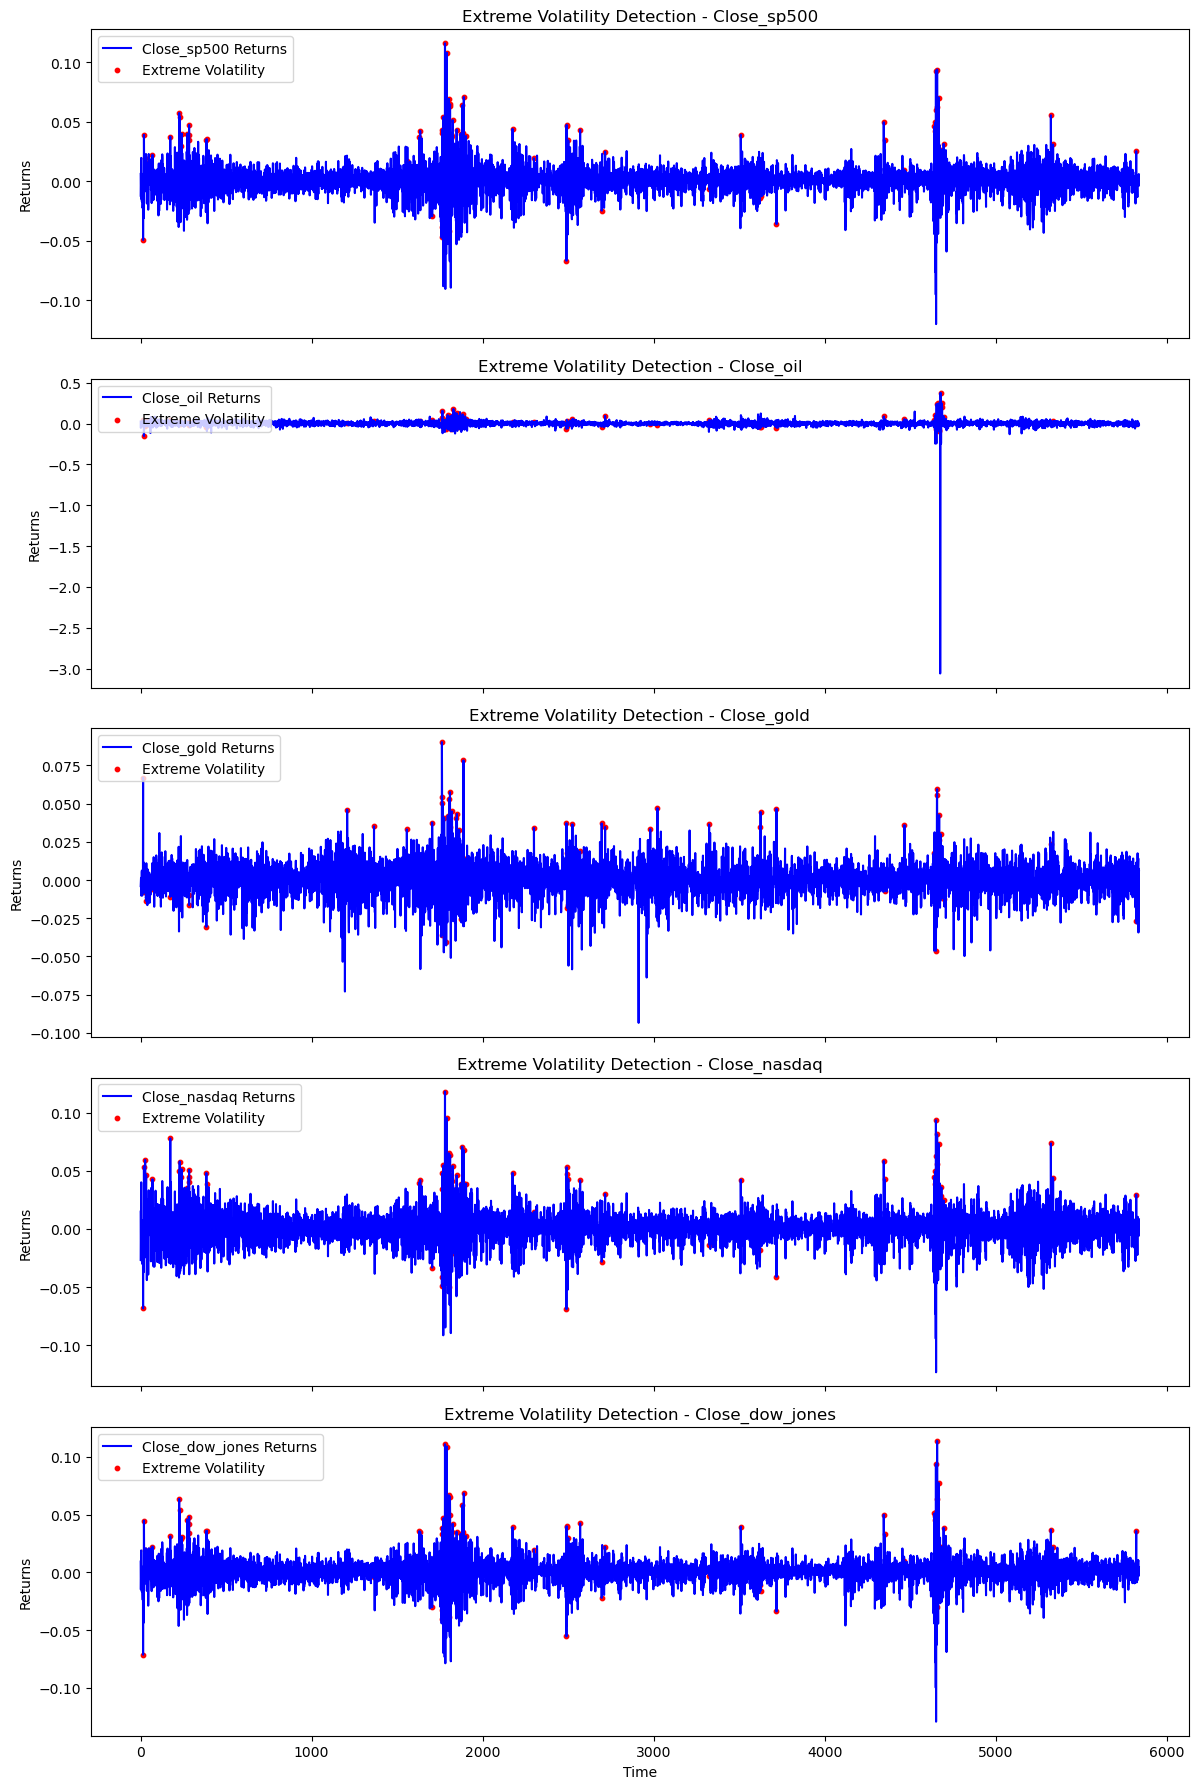

In [326]:
# question:
# Are there ways to detect unusual behavior in markets (such as extreme volatility or abnormal returns)?
# What technical indicators or macro factors might these abnormal behaviors be related to?

# -------------------------------------
# Step 1: Define a threshold for extreme volatility
# -------------------------------------
# Calculate the threshold for extreme volatility (3 standard deviations)
threshold = 3 * returns.std()

# Identify rows where any asset's return exceeds the threshold
extreme_volatility = returns[(returns > threshold).any(axis=1)]

# -------------------------------------
# Step 2: Plot extreme volatility for multiple assets
# -------------------------------------
# List of assets to visualize
assets_to_plot = ['Close_sp500', 'Close_oil', 'Close_gold', 'Close_nasdaq', 'Close_dow_jones']

# Initialize the figure and axes
fig, axes = plt.subplots(len(assets_to_plot), 1, figsize=(12, 18), sharex=True)

for i, asset in enumerate(assets_to_plot):
    ax = axes[i]
    # Plot returns for each asset
    ax.plot(returns.index, returns[asset], label=f'{asset} Returns', color='blue')
    # Highlight extreme volatility
    ax.scatter(
        extreme_volatility.index, 
        extreme_volatility[asset], 
        color='red', 
        label='Extreme Volatility', 
        s=10
    )
    # Customization
    ax.set_title(f"Extreme Volatility Detection - {asset}")
    ax.set_ylabel("Returns")
    ax.legend(loc='upper left')

# Add a common x-label
plt.xlabel("Time")
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'extreme_volatility_detection.png'))
plt.show()
plt.close()


## Asset Grouping and Portfolio Analysis

Checking for NaN or Inf values in data...
NaN values: 0
Inf values: 0


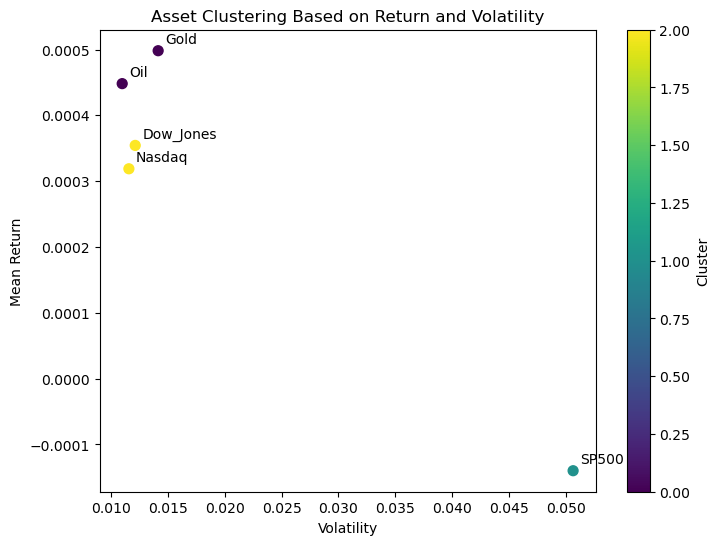

Target Return: 0.00040986463585241246
       Asset  Optimal Weight
0      SP500    3.892382e-03
1        Oil    5.545658e-01
2       Gold    1.053118e-01
3     Nasdaq    3.362301e-01
4  Dow_Jones    6.304507e-19


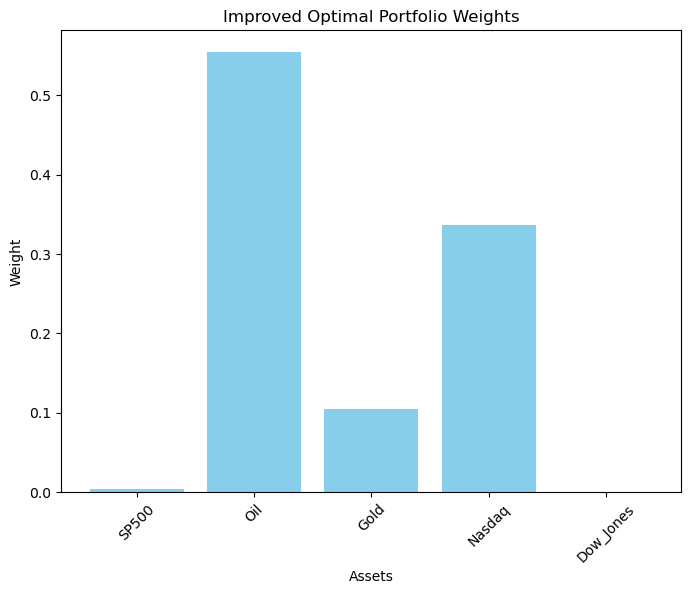

In [327]:
# question
# Can different markets be divided into stable groups (e.g. risky assets vs. safe-haven assets)?
# Do these groupings help investors with asset allocation (e.g., diversification of investment risk)?

import cvxpy as cp

# ----------------------------------------------
# Step 1: Check for NaN or Inf in Returns Data
# ----------------------------------------------
# Check for NaN or Inf values in returns
print("Checking for NaN or Inf values in data...")
print("NaN values:", np.isnan(returns).sum().sum())
print("Inf values:", np.isinf(returns).sum().sum())

# Replace Inf values with NaN for data cleaning
returns.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove any rows containing NaN values
returns.dropna(inplace=True)

# Ensure using correct asset names
returns.columns = ['SP500', 'Oil', 'Gold', 'Nasdaq', 'Dow_Jones']

# ----------------------------------------------
# Step 2: Compute Returns Statistics
# ----------------------------------------------
# Calculate mean returns and volatility for each asset
asset_stats = pd.DataFrame({
   'Mean Return': returns.mean(),
   'Volatility': returns.std()
})

# Handle any remaining extreme or missing values
asset_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
asset_stats.fillna(0, inplace=True)  # Replace NaN with 0 (or use mean/median if needed)

# ----------------------------------------------
# Step 3: K-Means Clustering for Asset Grouping
# ----------------------------------------------
# Standardize features for clustering
scaler = StandardScaler()
scaled_stats = scaler.fit_transform(asset_stats)

# Perform K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
asset_stats['Cluster'] = kmeans.fit_predict(scaled_stats)

# Visualize clustering results with asset labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(asset_stats['Volatility'], 
                    asset_stats['Mean Return'], 
                    c=asset_stats['Cluster'], 
                    cmap='viridis', 
                    s=50)

# Add asset labels to the plot
for idx, row in asset_stats.iterrows():
   plt.annotate(idx, 
               (row['Volatility'], row['Mean Return']),
               xytext=(5, 5), 
               textcoords='offset points')

plt.title("Asset Clustering Based on Return and Volatility")
plt.xlabel("Volatility")
plt.ylabel("Mean Return")
plt.colorbar(label='Cluster')
plt.savefig(os.path.join(save_path, 'asset_clustering.png'))
plt.show()
plt.close()

# ----------------------------------------------
# Step 4: Clip Extreme Values for Stability
# ----------------------------------------------
# Limit extreme values for more stable analysis
returns = returns.clip(lower=-0.5, upper=0.5)
asset_stats['Volatility'] = asset_stats['Volatility'].clip(upper=50)

# Recalculate statistics after clipping
asset_stats = pd.DataFrame({
   'Mean Return': returns.mean(),
   'Volatility': returns.std()
})

# ----------------------------------------------
# Step 5: Adjust Target Return
# ----------------------------------------------
# Calculate target return as mean across all assets
target_return = asset_stats['Mean Return'].mean()
print("Target Return:", target_return)

# ----------------------------------------------
# Step 6: Portfolio Optimization
# ----------------------------------------------
def optimize_portfolio(returns, target_return):
   """
   Optimize portfolio weights to minimize risk while meeting target return
   
   Parameters:
   returns: DataFrame of asset returns
   target_return: float, minimum required portfolio return
   
   Returns:
   array of optimal weights
   """
   n_assets = returns.shape[1]
   mu = returns.mean().values  # Expected returns
   cov_matrix = returns.cov().values  # Covariance matrix

   # Define optimization variables
   weights = cp.Variable(n_assets)
   portfolio_return = mu.T @ weights
   portfolio_risk = cp.quad_form(weights, cov_matrix)

   # Set optimization constraints
   constraints = [cp.sum(weights) == 1, weights >= 0, portfolio_return >= target_return]

   # Minimize portfolio variance subject to constraints
   problem = cp.Problem(cp.Minimize(portfolio_risk), constraints)
   problem.solve()

   return weights.value

# Re-optimize portfolio with target return
optimal_weights = optimize_portfolio(returns, target_return)

# Display optimization results
portfolio = pd.DataFrame({
   'Asset': returns.columns,
   'Optimal Weight': optimal_weights
})
print(portfolio)

# ----------------------------------------------
# Step 7: Visualize Portfolio Weights
# ----------------------------------------------
# Create bar plot of optimal weights
plt.figure(figsize=(8, 6))
plt.bar(portfolio['Asset'], portfolio['Optimal Weight'], color='skyblue')
plt.title("Improved Optimal Portfolio Weights")
plt.xlabel("Assets")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.savefig(os.path.join(save_path, 'portfolio_weights.png'))
plt.show()
plt.close()

{{< include summary.qmd >}} 